In [2]:
import pywt
import re
import numpy as np
import matplotlib.pyplot as plt
import math
import  os
import scipy.io as sio
import time
from scipy.io import loadmat

In [2]:
    data_path = r'data\12k Drive End Bearing Fault Data\B_default\118.mat'##原始数据地址
    save_path=r'nml_denoise_data'

In [3]:
def make_kernel(f):
    kernel = np.zeros((1, 2*f+1), np.float32)
    #print(kernel.shape)
    for d in range(1, f+1):
        for i in range(-d,d):
            kernel[0][f-i] += (1.0/((2*d+1)**2))
    return kernel/f

In [4]:
def nlm_1D_filter(src, f, t, h):
    m = len(src[0])
   # m = len(src) #测试用
    out = np.zeros((1, m), np.float32)
    # print(out)
    # memory for output

    # Replicate the boundaries of the input
    src_padding = np.pad(src[0], (0, f), mode='symmetric').astype(np.float32)
    #src_padding = np.pad(src, (0, f), mode='symmetric').astype(np.float32) #测试用
    # used kernel
    kernel = make_kernel(f)
    kernel = kernel / kernel.sum()

    for i in range(1, m):

        i1 = i + f

        if (i1 + f + 1) > src_padding.shape[0]:
            continue

        W1 = src_padding[i1 - f:i1 + f + 1]  # 领域窗口W1
        w_max = 0
        aver = 0
        weight_sum = 0
        rmin = max(i1 - t, f + 1);
        rmax = min(i1 + t, m + f);

        # 搜索窗口

        for r in range(rmin, rmax):
            if r == i1:
                continue
            elif (r + f + 1) > src_padding.shape[0]:
                continue
            else:
                W2 = src_padding[r - f:r + f + 1]  # 搜索区域内的相似窗口

                w0 = W2 - W1
                wc = np.dot(w0, w0)
                Dist2 = np.dot(kernel, wc).sum()
                w = np.exp(-Dist2 / h ** 2)
                if w > w_max:
                    w_max = w
                weight_sum = weight_sum + w
                aver = aver + w * src_padding[r]

        aver = aver + w_max * src_padding[i1]  # 自身领域取最大的权重
        weight_sum = weight_sum + w_max
        out[0, i] = aver / weight_sum

    return out

In [36]:
d_path=r'data\12k Drive End Bearing Fault Data\OR_default'
data1=loadmat(os.path.join(d_path, '130.mat'))
org_DE1 = data1['X' + '130' + '_DE_time']
data1=org_DE1.T
nmldata=nlm_1D_filter(data1,2,8,500)
print(nmldata)

[[ 0.          0.05329782 -0.02066492 ...  0.08293209  0.
   0.        ]]


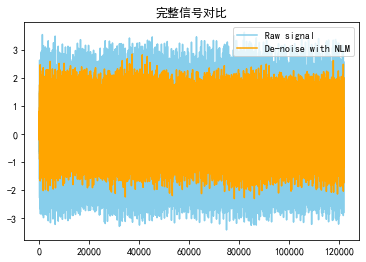

In [37]:
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.plot(data1[0],color='skyblue',label='Raw signal')
    plt.plot(nmldata[0]*10,color='orange',label='De-noise with NLM')
    plt.title('完整信号对比')
    plt.legend(loc=1) # 显示图例
    plt.show()

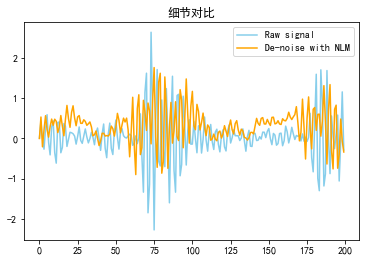

In [38]:
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.plot(data1[0,0:200],color='skyblue',label='Raw signal')
    plt.plot(nmldata[0,0:200]*10,color='orange',label='De-noise with NLM')
    plt.title('细节对比')
    plt.legend(loc=1) # 显示图例
    plt.show()

In [ ]:
    plt.figure()
    plt.subplot(2, 2, 1)
    plt.plot(org_DE1.T[0])
    plt.title("Raw signal")
    
    plt.subplot(2,2,2)
    fft1 = np.fft.fft(org_DE1.T[0])
    plt.plot(abs(fft1))
    plt.title("Raw signal")
    
    plt.subplot(2, 2,3)
    plt.plot(nmldata[0])
    plt.title("De-noised signal using wavelet techniques")
    
    plt.subplot(2,2,4)
    fft2 = np.fft.fft(nmldata[0])
    plt.plot(abs(fft2))
   
    plt.tight_layout()
    plt.show()


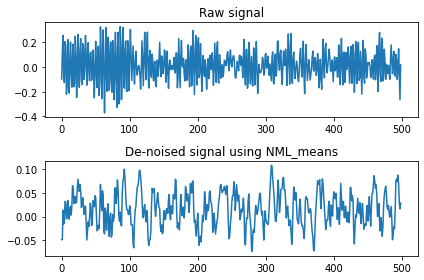

In [8]:
    plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(DE1[0,1:500])
    plt.title("Raw signal")
    
    plt.subplot(2, 1,2)
    plt.plot(nmldata[0,1:500])
    plt.title("De-noised signal using NML_means")

   
    plt.tight_layout()
    plt.show()


In [9]:
print(org_DE.T)
print(type(org_DE))
print(org_DE.shape[0])
org_DE1=[org_DE.T[0,0:1400]]
print(org_DE1)
print(len(org_DE1[0]))
A=np.pad(org_DE1[0], (0, 1), mode='symmetric').astype(np.float32)
print(A)

[[-0.0027614  -0.09632403  0.11370459 ... -0.07829373 -0.14911545
   0.02111657]]
<class 'numpy.ndarray'>
122571
[array([-0.0027614 , -0.09632403,  0.11370459, ...,  0.06854762,
       -0.02988806,  0.06042587])]
1400
[-0.0027614  -0.09632403  0.11370459 ... -0.02988806  0.06042587
  0.06042587]


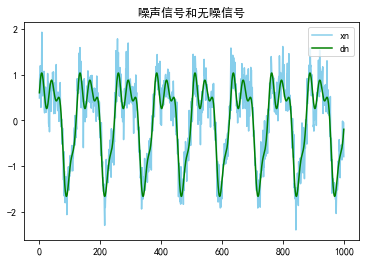

In [19]:
#模型测试
#生成带噪声的正弦信号
import random
data1=[]
index1=[]
data2=[]
for i in range(1,1000):
    data1.append(np.sin(5*i/100) + 0.5*np.cos(10*i/100)+0.3*np.sin(20*i/100))
    data2.append(np.sin(5*i/100) + 0.5*np.cos(10*i/100)+0.3*np.sin(20*i/100)+random.gauss(0,0.3))
    index1.append(i)
#x=np.linspace(1,3000,3000)
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.title('噪声信号和无噪信号')

plt.plot(data2,color='skyblue', label='xn')
plt.plot(data1,color='green', label='dn')
plt.legend(loc=1) # 显示图例
plt.show()
data1=(np.array(data1))
#print(data1)
#print(len(data1))
#print(type(data1))
#print(data1)0.2*(random.random()

Running time: 0.3701949119567871 Seconds


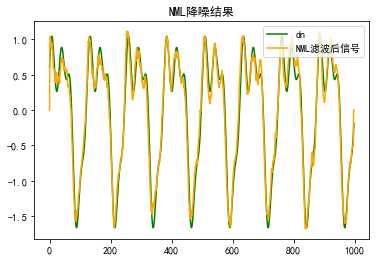

0.1456457126103653


In [21]:
#使用前需要注意修改原函数，数组和列表转换
import time

start=time.time()

data_test=nlm_1D_filter(data2,2,5,500)
end = time.time()
print('Running time: %s Seconds' % (end - start))
#print(data_test)
plt.title('NML降噪结果')
plt.plot(data1,color='green', label='dn')
plt.plot(data_test[0], color='orange',label='NML滤波后信号')
plt.legend(loc=1) # 显示图例
plt.show()

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
rmse1= rmse(data1,data_test[0])
print(rmse1)

In [86]:
#批量进行NML
def nonoise(data_path,save_path):
    start=time.time()
    file_1=os.listdir(data_path)
    for k in file_1:
        d_path=os.path.join(data_path, k)
        filenames = os.listdir(d_path)
        for i in filenames:
            data = loadmat(os.path.join(d_path ,i))
            names_number = re.findall(r"\d+", i)
            if int(names_number[0]) < 100:
                names_number = '0' + str(names_number[0])
            else:
                names_number = str(names_number[0])
                # 原始数据
            org_DE = data['X' + names_number + '_DE_time']
            org_FE = data['X' + names_number + '_FE_time']
            #org_BA = data['X' + names_number + '_BA_time']
            
            # 对数据降噪_小波变换法
            nonoise_DE = nlm_1D_filter(org_DE.T,10,2,5)
            nonoise_FE = nlm_1D_filter(org_DE.T,10,2,5)
            #nonoise_BA = wavelet_means(org_BA)
            # 降噪后的数据nonoise_DE、nonoise_FE、nonoise
            
            
            # 将数据存储为2维.mat数据
            sio.savemat(os.path.join(save_path,k, i),
                        {'X' + names_number + '_DE_time': nonoise_DE, 'X' + names_number + '_FE_time': nonoise_FE},
                        format='5', 
                        long_field_names=False,
                        do_compression=False,
                        oned_as='column')
            print("De-noise is done",str(os.path.join(d_path ,i)))
    print('DONE THE PROGRAM')
    print('Running time: %s Seconds'%(end-start))

path1 = r'data\12k Drive End Bearing Fault Data' ##原始数据地址
path2 = r'nml_denoise_data'
nonoise(path1,path2)

(1, 21)
(1, 21)
De-noise is done data\12k Drive End Bearing Fault Data\B_default\118.mat
(1, 21)
(1, 21)
De-noise is done data\12k Drive End Bearing Fault Data\B_default\119.mat
(1, 21)
(1, 21)
De-noise is done data\12k Drive End Bearing Fault Data\B_default\120.mat
(1, 21)
(1, 21)
De-noise is done data\12k Drive End Bearing Fault Data\B_default\121.mat
(1, 21)
(1, 21)
De-noise is done data\12k Drive End Bearing Fault Data\B_default\185.mat
(1, 21)
(1, 21)
De-noise is done data\12k Drive End Bearing Fault Data\B_default\186.mat
(1, 21)
(1, 21)
De-noise is done data\12k Drive End Bearing Fault Data\B_default\187.mat
(1, 21)
(1, 21)
De-noise is done data\12k Drive End Bearing Fault Data\B_default\188.mat
(1, 21)
(1, 21)
De-noise is done data\12k Drive End Bearing Fault Data\B_default\222.mat
(1, 21)
(1, 21)
De-noise is done data\12k Drive End Bearing Fault Data\B_default\223.mat
(1, 21)
(1, 21)
De-noise is done data\12k Drive End Bearing Fault Data\B_default\224.mat
(1, 21)
(1, 21)
De-no